# Compare WRF and Daymet Climate Variables

# 1. Import required Python libraries

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import LC_Grid_Labels as lc
import cartopy
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import IPython

## 1. a.  Print session and library version numbers

In [2]:
# Print IPython Session Info
print(IPython.sys_info())

# Print versions of libraries used in this notebook for traceability
print("\nPackage version numbers:\n")
print("xarray version: " + xr.__version__)
print("numpy version: " + np.__version__)
print("scipy version: " + scipy.__version__)
print("matplotlib version: " + matplotlib.__version__)
print("cartopy: " + cartopy.__version__)
print("wrf-python version: " + wrf.__version__+"\n")

{'commit_hash': '8c47bbcb3',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/lejoflores/miniconda3/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.5.0',
 'os_name': 'posix',
 'platform': 'Darwin-18.6.0-x86_64-i386-64bit',
 'sys_executable': '/Users/lejoflores/miniconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.7.3 (default, Mar 27 2019, 16:54:48) \n'
                '[Clang 4.0.1 (tags/RELEASE_401/final)]'}

Package version numbers:

xarray version: 0.12.1
numpy version: 1.16.3
scipy version: 1.2.1
matplotlib version: 3.0.3
cartopy: 0.17.0
wrf-python version: 1.3.2



# 2. Read in data using ```xarray```

In [3]:
wrf_dir = '/Users/lejoflores/data/WRF-NARR-1km-Daily/'

ds_wrf = xr.open_mfdataset(wrf_dir+'WRF-NARR*.nc')
print(ds_wrf)

daymet_dir = '/Users/lejoflores/data/Regridded_DayMet_ID/d02/prcp/'

ds_daymet = xr.open_mfdataset(daymet_dir+'Regridded_daymet_v3_prcp_*.nc4',concat_dim='Time')
print(ds_daymet)

<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMAX     (XTIME, south_north, west_east) float32 dask.array<shap

## 2. a. Create a ```datetime64``` time variable for Daymet

Note, Daymet uses a convention in which all years of record have 365 days, including leap years. For leap years, December 31 is truncated. As such, a ```datetime64``` object is created for the __first__ 365 days for all of the Daymet data years used in this analysis and added to the loaded Daymet data. See Daymet documentation here: [https://daymet.ornl.gov/overview](https://daymet.ornl.gov/overview) 

In [4]:
daymet_Syear = 1985
daymet_Eyear = 2016

years = np.linspace(daymet_Syear,daymet_Eyear,daymet_Eyear-daymet_Syear+1)

for year in years:
    daymet_Sdate = np.datetime64(str(int(year))+'-01-01')
    daymet_Edate = daymet_Sdate + np.timedelta64(365,'D') 

    daymet_yr = np.arange(daymet_Sdate,daymet_Edate,dtype='datetime64[D]')

    if(year==daymet_Syear):
        daymet_time = daymet_yr
    else:
        daymet_time = np.concatenate((daymet_time,daymet_yr))

ds_daymet['Time'] = daymet_time 
print(ds_daymet)

<xarray.Dataset>
Dimensions:  (Time: 11680, south_north: 327, west_east: 348)
Coordinates:
  * Time     (Time) datetime64[ns] 1985-01-01 1985-01-02 ... 2016-12-30
Dimensions without coordinates: south_north, west_east
Data variables:
    prcp     (Time, south_north, west_east) float64 dask.array<shape=(11680, 327, 348), chunksize=(365, 327, 348)>
Attributes:
    start_year:        1985
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...


## 2. b. Select the periods of overlap for both datasets

In [5]:
ds_wrf2 = ds_wrf.sel(XTIME=slice('1987-10-01','2016-09-30'))
print(ds_wrf2)

ds_daymet2 = ds_daymet.sel(Time=slice('1987-10-01','2016-09-30'))
print(ds_daymet2)

<xarray.Dataset>
Dimensions:  (XTIME: 10593, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2016-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10593, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10593, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10593, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10593, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10593, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<shape=(10593, 327, 348), chunksize=(366, 327, 348)>
    TMAX     (XTIME, south_north, west_east) float32 dask.array<shap

## 2. c. Create a month of the water year array to use as a grouping variable for both datasets

In [6]:
WY1_wrf = (ds_wrf2['XTIME.year'].where(ds_wrf2['XTIME.month'] >= 10).values + 1)
WY2_wrf = (ds_wrf2['XTIME.year'].where(ds_wrf2['XTIME.month'] < 10).values)
WY_wrf = np.nansum(np.column_stack((WY1_wrf,WY2_wrf)),axis=1)

WY_MO_wrf = ds_wrf2['XTIME.month'].values - 9
WY_MO_wrf[WY_MO_wrf<=0] += 12

In [7]:
WY1_dm = (ds_daymet2['Time.year'].where(ds_daymet2['Time.month'] >= 10).values + 1)
WY2_dm = (ds_daymet2['Time.year'].where(ds_daymet2['Time.month'] < 10).values)
WY_dm = np.nansum(np.column_stack((WY1_dm,WY2_dm)),axis=1)

WY_MO_dm = ds_daymet2['Time.month'].values - 9
WY_MO_dm[WY_MO_dm<=0] += 12

## 2. d. Append Water Year grouping vectors to WRF and Daymet datasets

In [8]:
ds_wrf2.coords['WY'] = xr.DataArray(WY_wrf.astype(int),dims='XTIME')
ds_wrf2.coords['WY_MO'] = xr.DataArray(WY_MO_wrf.astype(int),dims='XTIME')
print(ds_wrf)

ds_daymet2.coords['WY'] = xr.DataArray(WY_dm.astype(int),dims='Time')
ds_daymet2.coords['WY_MO'] = xr.DataArray(WY_MO_dm.astype(int),dims='Time')
print(ds_daymet2)

<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMAX     (XTIME, south_north, west_east) float32 dask.array<shap

# 3. Get seasonal long-term mean precipitation for  WRF and Daymet data 

In [9]:
wrf_prcp_OND = ds_wrf2.DPRCP[ds_wrf2.WY_MO.values<=3].groupby('WY').sum(dim='XTIME')
wrf_prcp_JFM = ds_wrf2.DPRCP[(ds_wrf2.WY_MO.values > 3) & (ds_wrf2.WY_MO.values <= 6)].groupby('WY').sum(dim='XTIME')
wrf_prcp_AMJ = ds_wrf2.DPRCP[(ds_wrf2.WY_MO.values > 6) & (ds_wrf2.WY_MO.values <= 9)].groupby('WY').sum(dim='XTIME')
wrf_prcp_JAS = ds_wrf2.DPRCP[ds_wrf2.WY_MO.values > 9].groupby('WY').sum(dim='XTIME')

daymet_prcp_OND = ds_daymet2.prcp[ds_daymet2.WY_MO.values<=3].groupby('WY').sum(dim='Time')
daymet_prcp_JFM = ds_daymet2.prcp[(ds_daymet2.WY_MO.values > 3) & (ds_daymet2.WY_MO.values <= 6)].groupby('WY').sum(dim='Time')
daymet_prcp_AMJ = ds_daymet2.prcp[(ds_daymet2.WY_MO.values > 6) & (ds_daymet2.WY_MO.values <= 9)].groupby('WY').sum(dim='Time')
daymet_prcp_JAS = ds_daymet2.prcp[ds_daymet2.WY_MO.values > 9].groupby('WY').sum(dim='Time')

prcp_diff_OND = wrf_prcp_OND.values - daymet_prcp_OND.values
prcp_diff_JFM = wrf_prcp_JFM.values - daymet_prcp_JFM.values
prcp_diff_AMJ = wrf_prcp_AMJ.values - daymet_prcp_AMJ.values
prcp_diff_JAS = wrf_prcp_JAS.values - daymet_prcp_JAS.values


# 4. Create plots characterizing precipitation differences between WRF and Daymet data

In [10]:
ds_wrfgeo = xr.open_dataset(wrf_dir+'wrf_geoinfo.nc')
nc_wrfgeo = nc.Dataset(wrf_dir+'wrf_geoinfo.nc')
cart_proj = get_cartopy(wrfin=nc_wrfgeo)

lats, lons = latlon_coords(ds_wrfgeo)

lat = lats[0]
lon = lons[0]

states = NaturalEarthFeature(category='cultural', scale='10m',facecolor='none',name='admin_1_states_provinces_shp')
rivers = NaturalEarthFeature(category='physical',scale='10m',facecolor='none',name='rivers_lake_centerlines')

plt.rcParams.update({'font.size': 12, 'font.family':'sans-serif'})

xticks = [-118,-117,-116,-115,-114,-113]
yticks = [42,43,44,45,46]

fig_ids = ['(a) OND','(b) JFM',
           '(c) AMJ','(d) JAS']

figsize_in = (13,13)
figres_dpi = 300
figext = '.tif'

contour_levels = 15

PrcpAvgDiff_fname = 'fig/14_PrcpWRF_Daymet_AvgDiff'+figext
PrcpStdDiff_fname = 'fig/15_PrcpWRF_Daymet_AvgDiff'+figext
PrcpAnnScat_fname = 'fig/S1_PrcAnnWRFvsDaymet'+figext
PrcpHexBin_fname  = 'fig/16_PrcpWRF_Daymet_hexbin'+figext

TminAvgDiff_fname = 'fig/17_TminWRF_Daymet_AvgDiff'+figext
TminStdDiff_fname = 'fig/18_TminWRF_Daymet_AvgDiff'+figext

TmaxAvgDiff_fname = 'fig/20_TmaxWRF_Daymet_AvgDiff'+figext
TmaxStdDiff_fname = 'fig/21_TmaxWRF_Daymet_AvgDiff'+figext


## 4. a. Plot difference in seasonal average precipitation totals

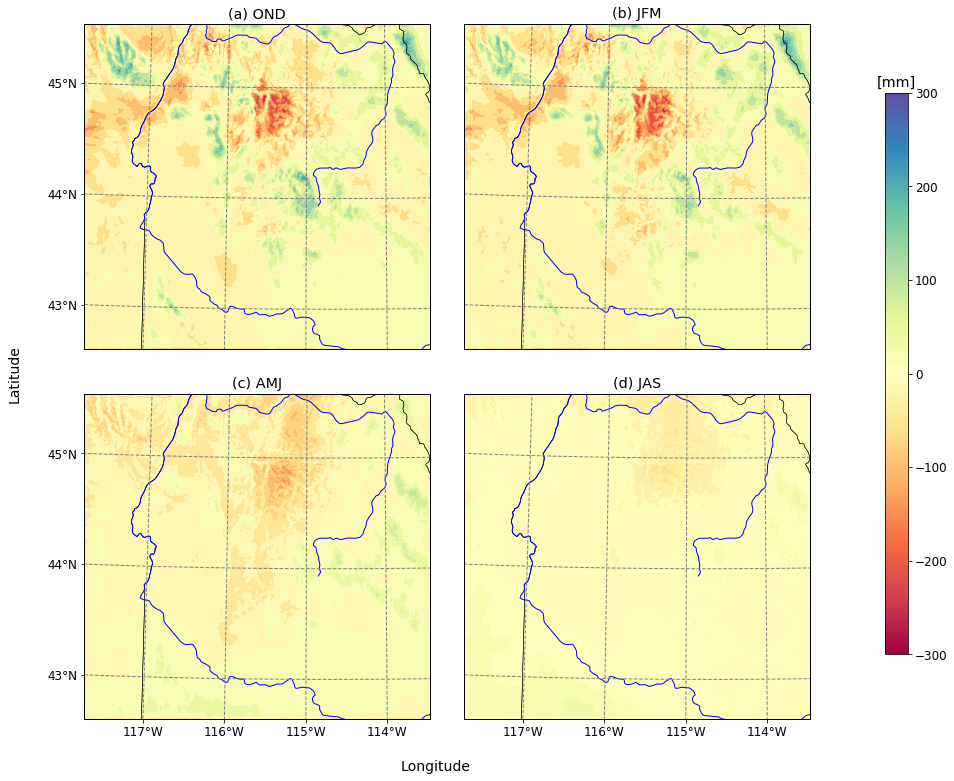

In [11]:
vmin_prcp = -300.0
vmax_prcp = 300.0

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),np.mean(prcp_diff_OND,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),np.mean(prcp_diff_JFM,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im21 = axes[1][0].contourf(to_np(lon),to_np(lat),np.mean(prcp_diff_AMJ,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),np.mean(prcp_diff_JAS,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==1):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral)
m.set_array(to_np(prcp_diff_OND))
m.set_clim(vmin_prcp, vmax_prcp)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[mm]')

plt.savefig(PrcpAvgDiff_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')
plt.show()

## 4. b. Plot the interannual variability in the difference between WRF and Daymet seasonal precipitation

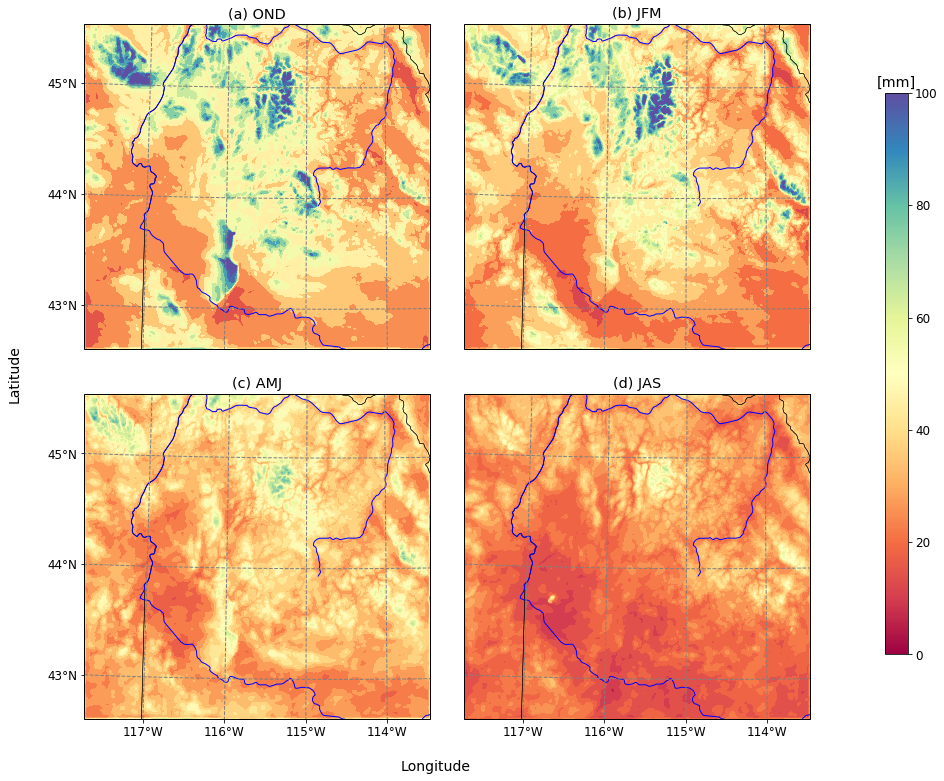

In [12]:
vmin_prcp = 0.0
vmax_prcp = 100.0

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),np.std(prcp_diff_OND,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),np.std(prcp_diff_JFM,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im21 = axes[1][0].contourf(to_np(lon),to_np(lat),np.std(prcp_diff_AMJ,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),np.std(prcp_diff_JAS,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==1):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral)
m.set_array(to_np(prcp_diff_OND))
m.set_clim(vmin_prcp, vmax_prcp)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[mm]')

plt.savefig(PrcpStdDiff_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')
plt.show()

## 4. d. Plot the domain-wide average seasonal precipitation for each year

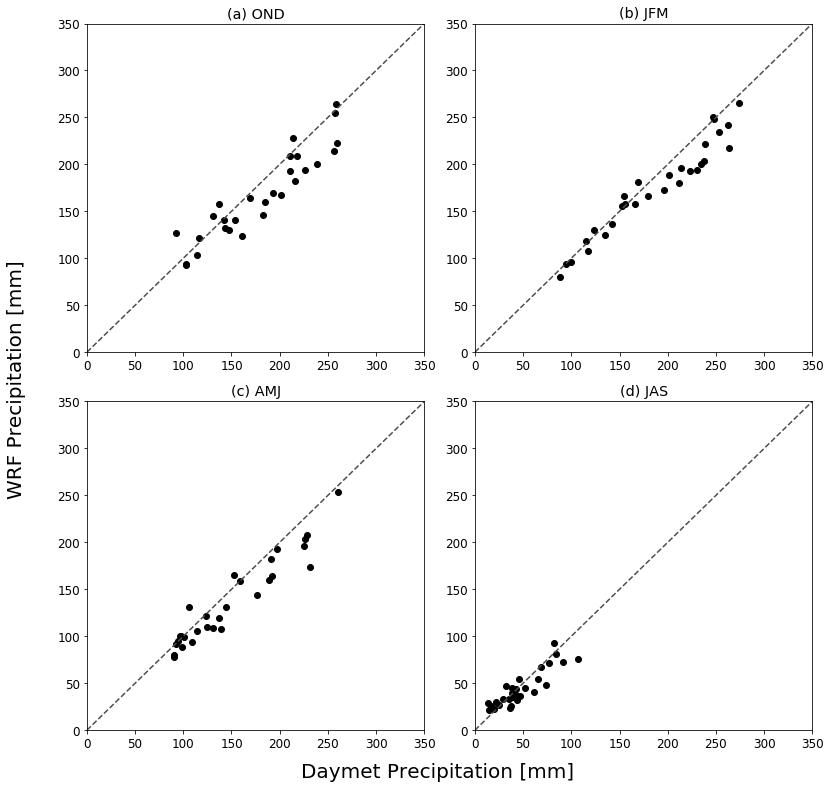

In [13]:
vmin_prcp = 0.0
vmax_prcp = 100.0

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in)
fig.subplots_adjust(wspace = .15, hspace = .15)

im11 = axes[0][0].plot(daymet_prcp_OND.mean(dim=('south_north','west_east')).values, 
                       wrf_prcp_OND.mean(dim=('south_north','west_east')).values,'ko')
im12 = axes[0][1].plot(daymet_prcp_JFM.mean(dim=('south_north','west_east')).values, 
                       wrf_prcp_JFM.mean(dim=('south_north','west_east')).values,'ko')
im21 = axes[1][0].plot(daymet_prcp_AMJ.mean(dim=('south_north','west_east')).values, 
                       wrf_prcp_AMJ.mean(dim=('south_north','west_east')).values,'ko')
im22 = axes[1][1].plot(daymet_prcp_JAS.mean(dim=('south_north','west_east')).values, 
                       wrf_prcp_JAS.mean(dim=('south_north','west_east')).values,'ko')

FigIter = 0

for ax in axes.flat:
    ax.set(xlim=(0, 350), ylim=(0, 350))
    diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.set_title(fig_ids[FigIter])

    FigIter += 1
    
fig.text(0.5, 0.08, 'Daymet Precipitation [mm]', ha='center', va='center', fontsize=20)
fig.text(0.05, 0.5, 'WRF Precipitation [mm]', ha='center', va='center', rotation='vertical', fontsize=20)

plt.savefig(PrcpAnnScat_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')

plt.show()

## 4. e. Create a hexbin plot to compare domain-wide average daily precipitation between the two datasets

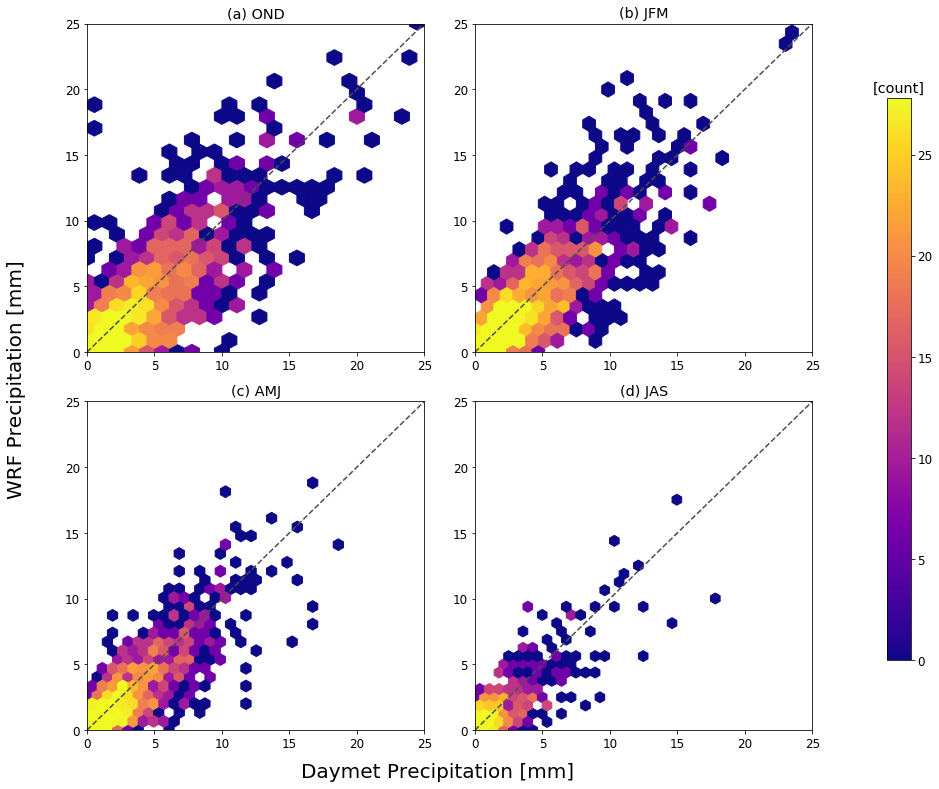

In [14]:
ds_wrf3 = ds_wrf2.sel(XTIME=ds_daymet2.Time)

wrf_prcp_OND_daily = ds_wrf3.DPRCP[ds_wrf3.WY_MO.values<=3]
wrf_prcp_JFM_daily = ds_wrf3.DPRCP[(ds_wrf3.WY_MO.values > 3) & (ds_wrf3.WY_MO.values <= 6)]
wrf_prcp_AMJ_daily = ds_wrf3.DPRCP[(ds_wrf3.WY_MO.values > 6) & (ds_wrf3.WY_MO.values <= 9)]
wrf_prcp_JAS_daily = ds_wrf3.DPRCP[ds_wrf3.WY_MO.values > 9]

daymet_prcp_OND_daily = ds_daymet2.prcp[ds_daymet2.WY_MO.values<=3]
daymet_prcp_JFM_daily = ds_daymet2.prcp[(ds_daymet2.WY_MO.values > 3) & (ds_daymet2.WY_MO.values <= 6)]
daymet_prcp_AMJ_daily = ds_daymet2.prcp[(ds_daymet2.WY_MO.values > 6) & (ds_daymet2.WY_MO.values <= 9)]
daymet_prcp_JAS_daily = ds_daymet2.prcp[ds_daymet2.WY_MO.values > 9]


vmin_prcp = 0.0
vmax_prcp = 100.0

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in)
fig.subplots_adjust(wspace = .15, hspace = .15)

im11 = axes[0][0].hexbin(daymet_prcp_OND_daily.mean(dim=('south_north','west_east')).values, 
                        wrf_prcp_OND_daily.mean(dim=('south_north','west_east')).values,gridsize=25,bins='log',
                        mincnt=1,vmax=25.0,cmap='plasma')
im12 = axes[0][1].hexbin(daymet_prcp_JFM_daily.mean(dim=('south_north','west_east')).values, 
                        wrf_prcp_JFM_daily.mean(dim=('south_north','west_east')).values,gridsize=25,bins='log',
                        mincnt=1,vmax=25.0,cmap='plasma')
im21 = axes[1][0].hexbin(daymet_prcp_AMJ_daily.mean(dim=('south_north','west_east')).values, 
                        wrf_prcp_AMJ_daily.mean(dim=('south_north','west_east')).values,gridsize=25,bins='log',
                        mincnt=1,vmax=25.0,cmap='plasma')
im22 = axes[1][1].hexbin(daymet_prcp_JAS_daily.mean(dim=('south_north','west_east')).values, 
                        wrf_prcp_JAS_daily.mean(dim=('south_north','west_east')).values,gridsize=25,bins='log',
                        mincnt=1,vmax=25.0,cmap='plasma')

FigIter = 0

for ax in axes.flat:
    ax.set(xlim=(0, 25), ylim=(0, 25))
    diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.set_title(fig_ids[FigIter])

    FigIter += 1
    
cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.plasma)
m.set_array(daymet_prcp_OND_daily.mean(dim=('south_north','west_east')).values)
#m.set_clim(vmin_prcp, vmax_prcp)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[count]')

fig.text(0.5, 0.08, 'Daymet Precipitation [mm]', ha='center', va='center', fontsize=20)
fig.text(0.05, 0.5, 'WRF Precipitation [mm]', ha='center', va='center', rotation='vertical', fontsize=20)

plt.savefig(PrcpHexBin_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')

plt.show()